![](/Pics/PASSSummitLogo.JPG)

# Creating Custom R Visualizations in Jupyter Lab using ggplot2

### Prerequisites
- Install Jupyter Lab
    - Install Anaconda. Get installer [here](https://www.anaconda.com/download/).
    - Install Jupyter Lab
        - Open up the Anaconda Commmand Prompt
        - Enter the following code snippet:

        ```
            conda install -c conda-forge jupyterlab 
        ``` <br>  
- Instructions of how to install the R Kernel in Jupyter Notebook can be found in this [YouTube](https://www.youtube.com/watch?v=SXBxKe8sK6I) video.

- [List](https://github.com/jupyter/jupyter/wiki/Jupyter-kernels) of available kernels for Jupyter Notebooks.

- [Link](https://ipython.readthedocs.io/en/stable/interactive/magics.html) to documentation for iPython magics.

- [Link](https://ipython.org/ipython-doc/2/config/extensions/rmagic.html) to documentation for R magics.

- [Link](https://www.analyticsvidhya.com/blog/2018/05/starters-guide-jupyter-notebook/) to useful Jupyter Notebook tips. 

- [Link](http://maxmelnick.com/2016/04/19/python-beginner-tips-and-tricks.html) to Jupyter Notebook keyboard shortcuts.

- [Link](https://www.datacamp.com/community/podcast/project-jupyter-interactive-computing) to a *Data Framed* podcast about Jupyter Lab and the direction of the Jupyter project.


### What is ggplot2

The [ggplot2](https://ggplot2.tidyverse.org/) package is a R package used to create custom visualizations. It is based on the *layered grammar of graphics*. The ggplot2 package is very extensive and a thorough coverage can not be done in one session but here are some features I would like to point out:

- **Aesthetic (aes)**: describes how the variables (columns) in your data are mapped to aesthetic attributes such as position, size, color, ect. The mapping can be done in the ggplot function or in a geom function. If done in the ggplot function it will be available to all layers if done in the geom it will only be available for just that layer.  
    
- **Layers**: The geometric objects (bars, points, boxplots, ect.) that you use to visualize your data. They are defined by 5 basic parts:
    - Data
    - Mapping
    - Statistical Transformation
    - Geometric Object
    - Position Adjustment
 
- **Themes**: Controls the non-data elements of your chart. Examples include things like chart title, background colors, font size, and ect.

Now that we have a high level understand about the ggplot2 package lets take a quick look at the other packages we will be using. Here is a list of the packages we will be using in this script:

- [tidyverse](https://www.tidyverse.org/)  The tidyverse package is a combination of packages that shares the same API design and they are designed to make doing data science easier. We will be using the readr package to read in data, the dplyr package to reshape the data, and the ggplot2 package to create the visualization.

- [ggrepel](https://cran.r-project.org/web/packages/ggrepel/ggrepel.pdf):  Sometimes when you plot data your data labels overlap. The ggrepel package reposition overlapping labels so that they are easier to read.

- [ggthemes](https://cran.r-project.org/web/packages/ggthemes/ggthemes.pdf):  This package contains themes that can be used to format your non-data elements based on pre-defined styles

- [scales](https://cran.r-project.org/web/packages/scales/scales.pdf): This package has multiple uses but we will be using it to rescale our data using the *rescale* function

- [stringi](https://cran.r-project.org/web/packages/stringi/stringi.pdf): The stringi package contains many functions that you can use for string manipulation

I will point out where these packages are being used throughout the talk.

When we pass our data to R from Power BI our data needs to be in the proper shape for our visualization. We need to perform a test to make sure are data is in the right test and if it is not we need to handle it by returning a blank graph. Below is a template that I use to do this.

### Template for a custom R visual in Power BI

```R
        if (< dataset test code >) {

            # <Put code to generate graph here>
            
        } else {
    
            p <- ggplot(dataset, aes(x = '<my x variable>', y = '<my y variable>')) +
                 geom_blank() +
                 scale_x_continuous(
                      labels = NULL
                    , breaks = NULL
                 ) +
                 scale_y_continuous(
                      labels = NULL
                    , breaks = NULL
                 ) +
                 labs(x = NULL, y = NULL) +
                 theme_classic()
            p
        }
```

Load the packages that we will use to build the visualization. 

In [1]:
library(tidyverse)
library(ggrepel)
library(ggthemes)
library(scales)
library(stringi)

-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 2.2.1     v purrr   0.2.4
v tibble  1.4.2     v dplyr   0.7.5
v tidyr   0.8.1     v stringr 1.3.1
v readr   1.1.1     v forcats 0.3.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Attaching package: 'scales'

The following object is masked from 'package:purrr':

    discard

The following object is masked from 'package:readr':

    col_factor



The code below reads in our data from a csv file to a R data frame.

In [2]:
filepath <- "./Data/dataset.csv"
dataset <- read_csv(filepath)
head(dataset)

Parsed with column specification:
cols(
  Index = col_integer(),
  Player = col_character(),
  Year = col_integer(),
  `Position Group` = col_character(),
  Position = col_character(),
  BenchReps = col_integer(),
  `40YD` = col_double()
)


Index,Player,Year,Position Group,Position,BenchReps,40YD
191,Marcell Ateman,2018,Wide Receiver,WR,13,4.62
182,Braxton Berrios,2018,Wide Receiver,WR,11,0.00
174,Deontay Burnett,2018,Wide Receiver,WR,0,0.00
172,Deon Cain,2018,Wide Receiver,WR,11,4.43
171,Antonio Callaway,2018,Wide Receiver,WR,0,4.41
170,Dylan Cantrell,2018,Wide Receiver,WR,18,4.59


We are developing a quad chart for the NFL prospects based on the bench press and 40 yard dash. In order to do so the players in the quard chart must have bench press and 40 yard information. That information also needs to be on the same scale. The code below uses the [dplyr](https://dplyr.tidyverse.org/) package from [tidyverse](https://www.tidyverse.org/) to remove unwanted records and the [scales](https://cran.r-project.org/web/packages/scales/scales.pdf) package to rescale our data.

In [3]:
graph_data <-
    dataset %>%
    filter(`40YD` != 0 & BenchReps != 0) %>%
    mutate(
        Scaled.40YD = 
            round(rescale(`40YD` * -1, to = c(-10, 10)), 1)
        ,Scaled.BenchReps = 
            round(rescale(BenchReps, to = c(-10, 10)), 1)
    )
head(graph_data)

Index,Player,Year,Position Group,Position,BenchReps,40YD,Scaled.40YD,Scaled.BenchReps
191,Marcell Ateman,2018,Wide Receiver,WR,13,4.62,-8.2,-1.7
172,Deon Cain,2018,Wide Receiver,WR,11,4.43,9.1,-5.0
170,Dylan Cantrell,2018,Wide Receiver,WR,18,4.59,-5.5,6.7
162,Simmie Cobbs,2018,Wide Receiver,WR,11,4.64,-10.0,-5.0
159,Keke Coutee,2018,Wide Receiver,WR,14,4.43,9.1,0.0
139,Michael Gallup,2018,Wide Receiver,WR,10,4.51,1.8,-6.7


We know that our data is in the correct shape so now we can start building our visualization. We will do so in the same manner that Bob Ross used to do when he did his paintings. We will start with a basic quad chart then add layers until we get to the chart that we want.

![Bob Ross](./Pics/Bob_at_Easel.jpg)

The code below produces the basis of our quad chart

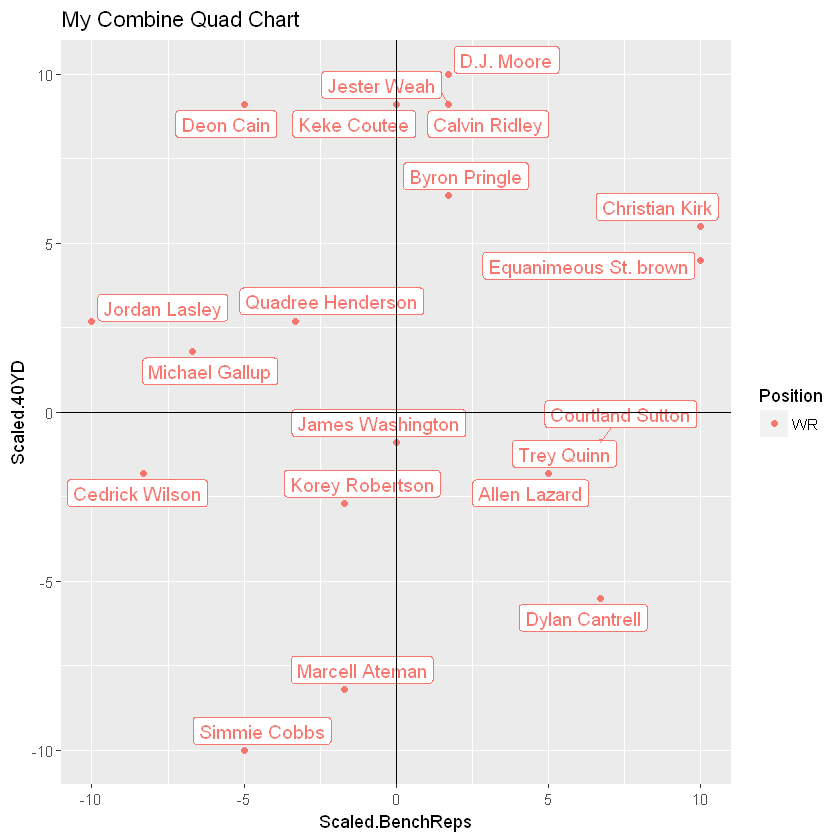

In [4]:
p <- ggplot(graph_data, aes(x = Scaled.BenchReps, y = Scaled.40YD, col = Position)) +
     geom_point() +
     geom_label_repel(aes(label = Player), size = 4, show.legend = FALSE) +
     geom_hline(yintercept = 0) +
     geom_vline(xintercept = 0) + 
     labs(
         title = "My Combine Quad Chart"
     )
p

The *bquote* function in R allows you to combine strings with mathematical equations. I used that feature as a hack to append the arrows to the axis titles.

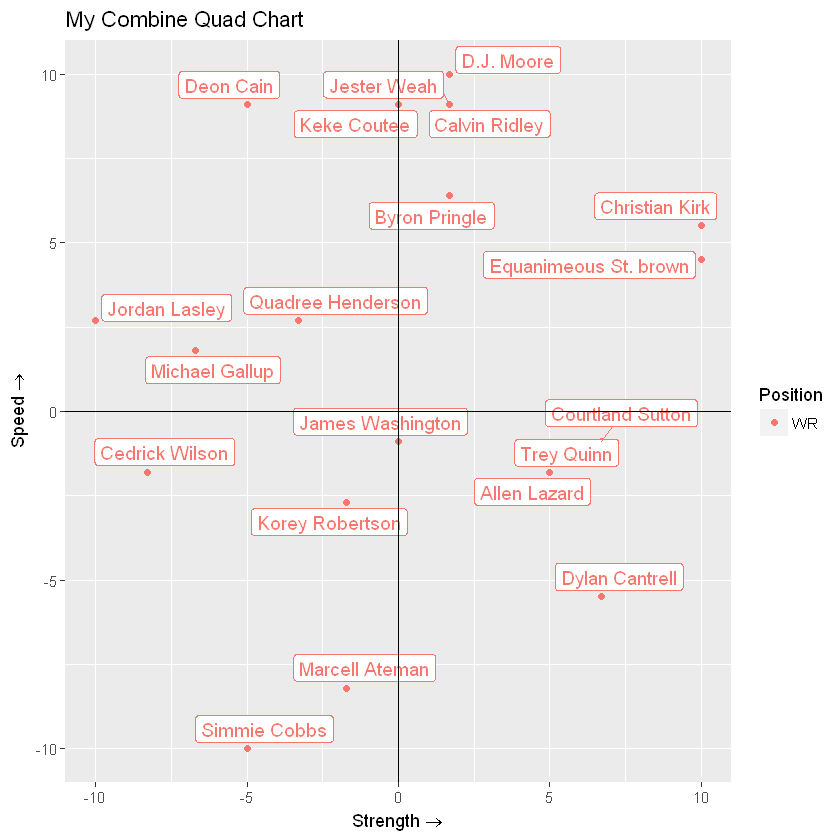

In [5]:
p <- p +
     xlab(bquote("Strength" ~ symbol('\256'))) +
     ylab(bquote("Speed" ~ symbol('\256')))
p

The code below draws a rectangular border for our labels and fills it with the color "grey80". You can go [here](http://sape.inf.usi.ch/quick-reference/ggplot2/colour) to get a list of colors available in ggplot2.

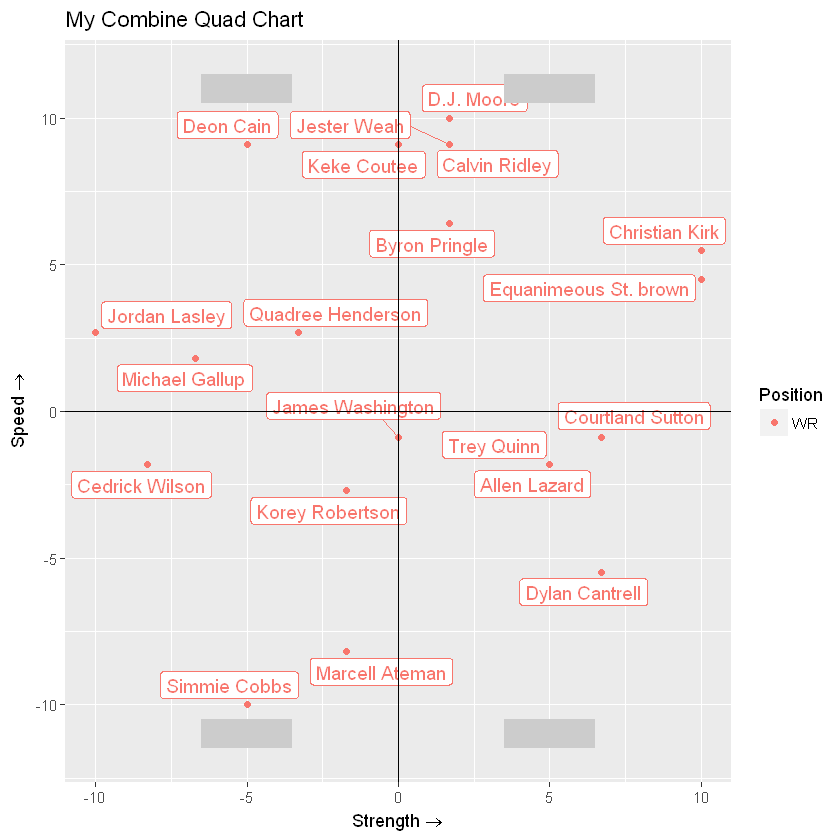

In [6]:
p <- p +
     annotate("rect", xmin = -3.5, xmax = -6.5, ymin = -11.5, ymax = -10.5, fill = "grey80") +
     annotate("rect", xmin = -3.5, xmax = -6.5, ymin = 10.5, ymax = 11.5, fill = "grey80") +
     annotate("rect", xmin = 3.5, xmax = 6.5, ymin = -11.5, ymax = -10.5, fill = "grey80") +
     annotate("rect", xmin = 3.5, xmax = 6.5, ymin = 10.5, ymax = 11.5, fill = "grey80")
p

Code below labels our quadrants

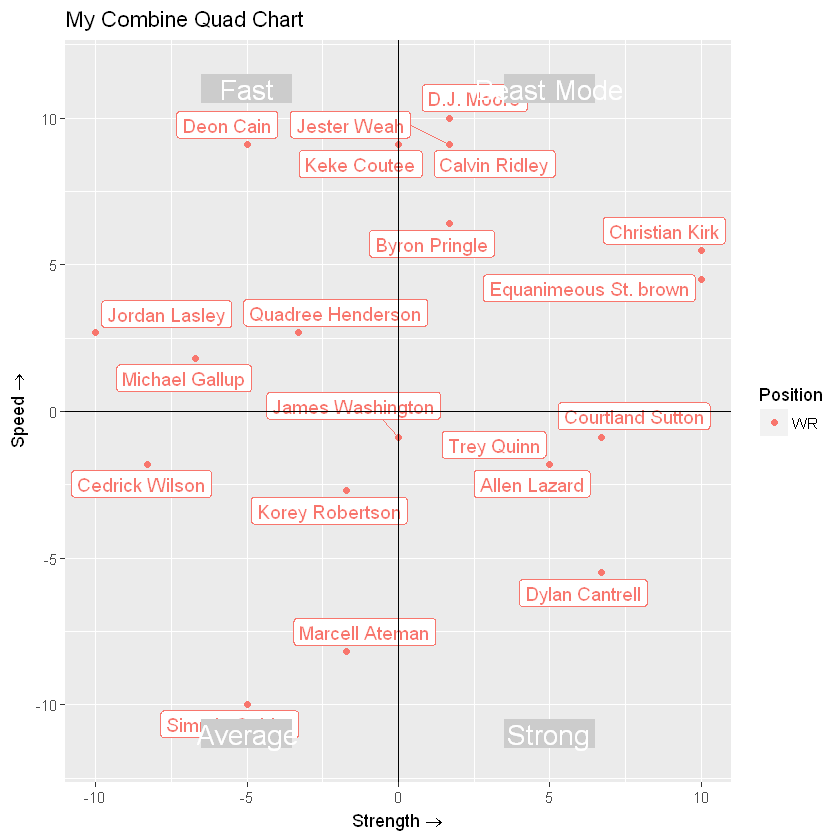

In [7]:
p <- p +
     # quad labels
     annotate("text", x = -5, y = -11, label = "Average", color = "white", size = 6) +
     annotate("text", x = -5, y = 11, label = "Fast", color = "white", size = 6) +
     annotate("text", x = 5, y = -11, label = "Strong", color = "white", size = 6) +
     annotate("text", x = 5, y = 11, label = "Beast Mode", color = "white", size = 6)
p

We apply formatting to our chart based on the principals developed by the renowned data visualization expert, [Edward Tufte](https://bit.ly/2s0WGc9).

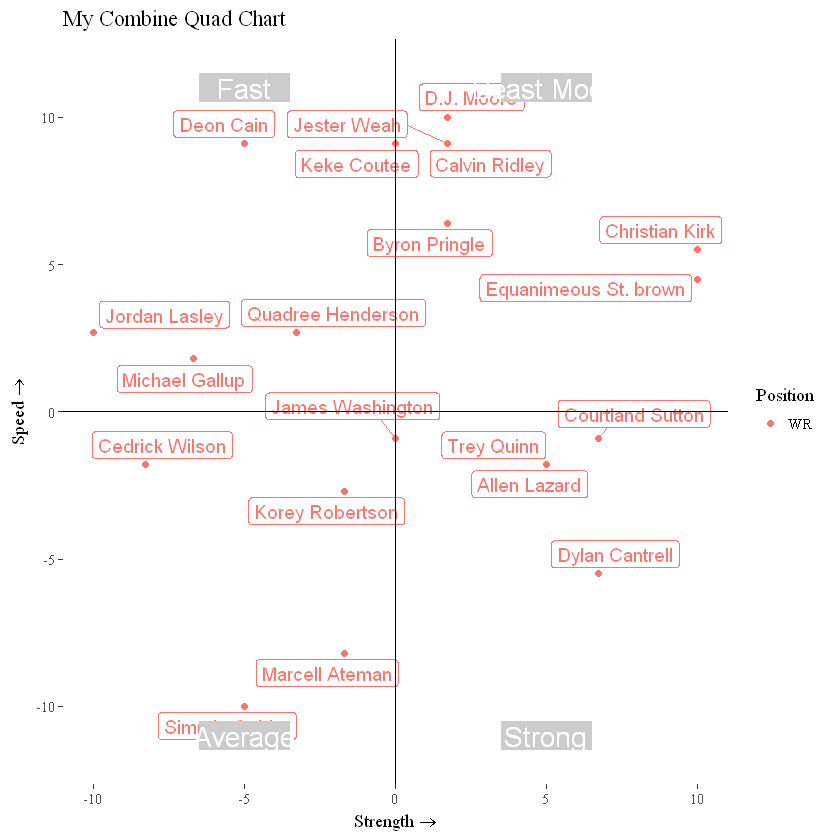

In [8]:
p <- p +
     theme_tufte()
p

We color quadrants 2 & 3

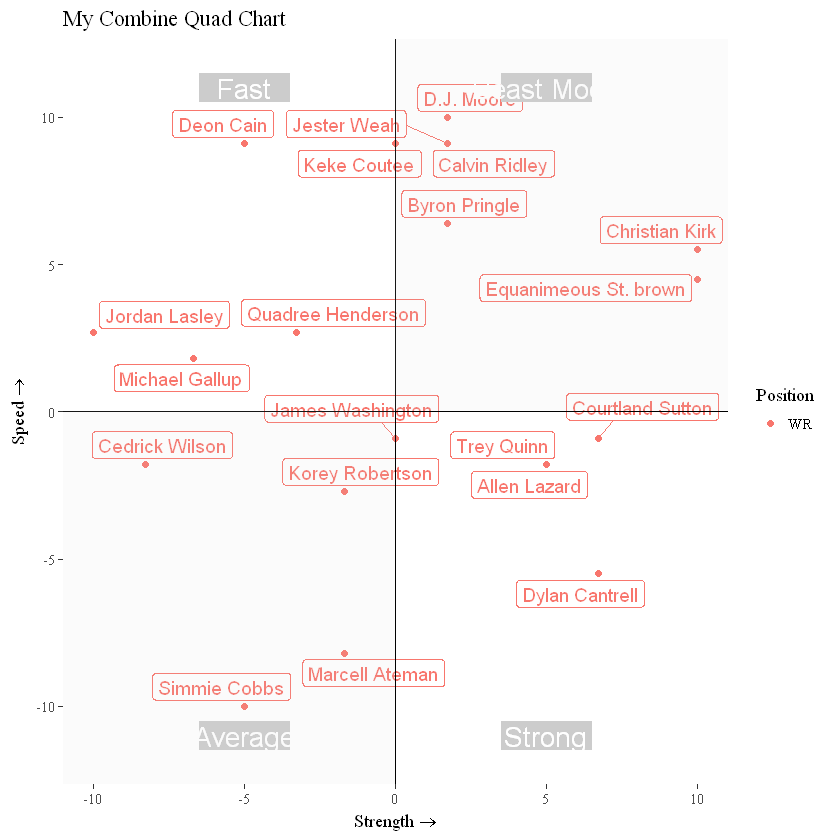

In [9]:
p <- p +
     annotate("rect", xmin = -Inf, xmax = 0.0, ymin = -Inf, ymax = 0, alpha = 0.1, fill = "lightgrey") +
     annotate("rect", xmin = 0.0, xmax = Inf, ymin = 0.0, ymax = Inf, alpha = 0.1, fill = "lightgrey")
p

We now have the graph built. Now we need to add some dynamic information to our graph to give the end user important information. We will add a dynamic title, dynamic subtitle, and a caption that will give the end user the source of our data set. Before we start building the dynamic elements let's take a look at our data set to see what information we have available to build our dynamic elements.

In [10]:
head(dataset)

Index,Player,Year,Position Group,Position,BenchReps,40YD
191,Marcell Ateman,2018,Wide Receiver,WR,13,4.62
182,Braxton Berrios,2018,Wide Receiver,WR,11,0.00
174,Deontay Burnett,2018,Wide Receiver,WR,0,0.00
172,Deon Cain,2018,Wide Receiver,WR,11,4.43
171,Antonio Callaway,2018,Wide Receiver,WR,0,4.41
170,Dylan Cantrell,2018,Wide Receiver,WR,18,4.59


Dynamically builds our chart title

In [11]:
selected_position <- unique(dataset$`Position Group`)
selected_year <- unique(dataset$Year)
chart.title <- paste(selected_year, "Combine Quad Chart for", selected_position, sep = " ")
chart.title

[1] "2018 Combine Quad Chart for Wide Receiver"

Our dynamic subtitle will show up to 7 bullet points. The categories are:
- Players that did not run the 40 yard dash
- Players that did not perform the bench press
- Players that did not perform the bench press and 40 yard dash
- Players that did the best in the bench press
- Players that did the worse in the bench press
- Players that did the best in the 40 yard dash
- Players that did the worse in the 40 yard dash

Now let's build our dynamic titles!

Code below subsets the dataframe to only include the *Player* variable that did not run the 40 but did the bench press

In [12]:
No40YDSubtitle <-
    dataset$Player[which(dataset$`40YD` == 0 & dataset$BenchReps != 0)]
No40YDSubtitle

[1] "Braxton Berrios" "Anthony Miller"

Code below converts the variable fom above to a character vector

In [13]:
No40YDSubtitle <- 
    dataset$Player[which(dataset$`40YD` == 0 & dataset$BenchReps != 0)] %>%
    as.character()
No40YDSubtitle

[1] "Braxton Berrios" "Anthony Miller"

Code below converts the variable from above from a character vector to a string with each element separated by a *comma*

In [14]:
No40YDSubtitle <- 
    dataset$Player[which(dataset$`40YD` == 0 & dataset$BenchReps != 0)] %>%
    as.character() %>%
    paste(collapse = ", ")
No40YDSubtitle

[1] "Braxton Berrios, Anthony Miller"

Code below replaces the last comma in the string with *", and"*

In [15]:
No40YDSubtitle <- 
    dataset$Player[which(dataset$`40YD` == 0 & dataset$BenchReps != 0)] %>%
    as.character() %>%
    paste(collapse = ", ") %>%
    stri_replace_last_fixed(", ", ", and ")
No40YDSubtitle

[1] "Braxton Berrios, and Anthony Miller"

The code below uses the paste0 function to append a "- " to the beginning of the string from the cell above

In [16]:
No40YDSubtitle <- 
    dataset$Player[which(dataset$`40YD` == 0 & dataset$BenchReps != 0)] %>%
    as.character() %>%
    paste(collapse = ", ") %>%
    stri_replace_last_fixed(", ", ", and ") %>%
    paste0("- ", .," did not run the 40YD.")
No40YDSubtitle

[1] "- Braxton Berrios, and Anthony Miller did not run the 40YD."

The code below passes the results from what was created in the cell above to the str_wrap function. The str_wrap function allows you to control the width of the string via the ***width*** argument and control the indentation of all subsequent lines via the ***extent*** argument.

In [17]:
No40YDSubtitle <- 
    dataset$Player[which(dataset$`40YD` == 0 & dataset$BenchReps != 0)] %>%
    as.character() %>%
    paste(collapse = ", ") %>%
    stri_replace_last_fixed(", ", ", and ") %>%
    paste0("- ", .," did not run the 40YD.") %>%
    str_wrap(width = 70, exdent = 2)
No40YDSubtitle

[1] "- Braxton Berrios, and Anthony Miller did not run the 40YD."

Sets a variable that tells us if there are athletes in this category. Will be used later on

In [18]:
No40YDSubtitleHaveAthletes <-
    dataset$Player[which(dataset$`40YD` == 0 & dataset$BenchReps != 0)] %>%
    length() %>%
    {ifelse(. > 0, "Y", "N")}

The code below does the same for the other "No" categories and creates variables that have the counts for each category. The ****SubtitleHaveAthletes*** variables will be used later to help determine if we need to add a subtitle for that category to our chart.

In [19]:
NoBenchPressSubtitle <- 
    dataset$Player[which(dataset$`40YD` != 0 & dataset$BenchReps == 0)] %>%
    as.character() %>%
    paste(collapse = ", ") %>%
    stri_replace_last_fixed(", ", ", and ") %>%
    paste0("- ", .," did not participate in the benchpress.") %>%
    str_wrap(width = 70, exdent = 2)

NoBenchPressSubtitleHaveAthletes <- 
    dataset$Player[which(dataset$`40YD` != 0 & dataset$BenchReps == 0)] %>%
    length() %>%
    {ifelse(. > 0, "Y", "N")}

No40YDAndBenchPressSubtitle <- 
    dataset$Player[which(dataset$`40YD` == 0 & dataset$BenchReps == 0)] %>%
    as.character() %>%
    paste(collapse = ", ") %>%
    stri_replace_last_fixed(", ", ", and ") %>%
    paste0("- ", .," did not participate in either the 40YD or in the benchpress.") %>%
    str_wrap(width = 70, exdent = 2)

No40YDAndBenchPressSubtitleHaveAthletes <- 
    dataset$Player[which(dataset$`40YD` == 0 & dataset$BenchReps == 0)] %>%
    length() %>%
    {ifelse(. > 0, "Y", "N")}

The code below shows what the output looks like

In [20]:
No40YDSubtitle
NoBenchPressSubtitle
No40YDAndBenchPressSubtitle

[1] "- Braxton Berrios, and Anthony Miller did not run the 40YD."

[1] "- Antonio Callaway, Auden Tate, and Javon Wims did not participate in\n  the benchpress."

[1] "- Deontay Burnett, Daesean Hamilton, Dante Pettis, and Cam Phillips\n  did not participate in either the 40YD or in the benchpress."

The code cells below builds the subtitles for best benchpress, worst bench press, best 40 yard dash, and worst 40 yard dash. We have a variable that represents the best benchpress, worst benchpress, best 40yd, and worst 40yd. We also have the ****Athletes_cv*** variables to list the athletes that are in each category.

In [21]:
    WorstBench <- min(dataset$BenchReps[dataset$BenchReps != 0])    

    WorstBenchAthletes_cv <- 
        dataset$Player[which(dataset$BenchReps == WorstBench)] %>%
        as.character()

    WorstBenchAthletesCount <- length(WorstBenchAthletes_cv)

    WorstBenchAthletes <- 
        WorstBenchAthletes_cv %>%
        paste(collapse = ", ") %>%
        stri_replace_last_fixed(", ", ", and ")

    WorstBenchSubtitle <- 
        paste0(
            "- The lowest number of reps for the benchpress was ",
            WorstBench,
            ". ",
            WorstBenchAthletes,
            ifelse(WorstBenchAthletesCount > 1, " are ", " is "),
            "in this group"
        ) %>%
        str_wrap(width = 70, exdent = 2)


In [22]:
BestBench <- max(dataset$BenchReps)

BestBenchAthletes_cv <-
    dataset$Player[which(dataset$BenchReps == BestBench)] %>%
    as.character()
    
BestBenchAthletesCount <- length(BestBenchAthletes_cv)

BestBenchAthletes <- 
    BestBenchAthletes_cv %>%
    paste(collapse = ", ") %>%
    stri_replace_last_fixed(", ", ", and ")

BestBenchSubtitle <- 
    paste0(
        "- The highest number of reps for the benchpress was ",
        BestBench,
        ". ",
        BestBenchAthletes,
        ifelse(BestBenchAthletesCount > 1, " are ", " is "),
        "in this group"
    ) %>%
    str_wrap(width = 70, exdent = 2)

In [23]:
    Worst40YD <- max(dataset$`40YD`)

    Worst40YDAthletes_cv <- 
        dataset$Player[which(dataset$`40YD` == Worst40YD)] %>%
        as.character()

    Worst40YDAthletesCount <- length(Worst40YDAthletes_cv)

    Worst40YDAthletes <- 
        Worst40YDAthletes_cv %>%
        paste(collapse = ", ") %>%
        stri_replace_last_fixed(", ", ", and ")

    Worst40YDSubtitle <- 
        paste0(
            "- The slowest time for the 40YD was ",
            Worst40YD,
            ". ",
            Worst40YDAthletes,
            ifelse(Worst40YDAthletesCount > 1, " are ", " is "),
            "in this group"
        ) %>%
        str_wrap(width = 70, exdent = 2)

In [24]:
    Best40YD <- min(dataset$`40YD`[dataset$`40YD` != 0])

    Best40YDAthletes_cv <- 
        dataset$Player[which(dataset$`40YD` == Best40YD)] %>%
        as.character()

    Best40YDAthletesCount <- length(Best40YDAthletes_cv)

    Best40YDAthletes <- 
        Best40YDAthletes_cv %>%
        paste(collapse = ", ") %>%
        stri_replace_last_fixed(", ", ", and ")

    Best40YDSubtitle <- 
        paste0(
            "- The fastest time for the 40YD was ",
            Best40YD,
            ". ",
            Best40YDAthletes,
            ifelse(Best40YDAthletesCount > 1, " are ", " is "),
            "in this group"
        ) %>%
        str_wrap(width = 70, exdent = 2)

The code below combines all the subtitles elements from above to build the chart title. The line feeds does not print out properly in our Jupyter Notebook but it does in ggplot.

In [25]:
chartsubtitle <-
    paste0(
        ifelse(BestBenchAthletesCount == 0,"",paste0("\n", BestBenchSubtitle)),
        ifelse(WorstBenchAthletesCount == 0,"",paste0("\n", WorstBenchSubtitle)),
        ifelse(Best40YDAthletesCount == 0,"",paste0("\n", Best40YDSubtitle)),
        ifelse(Worst40YDAthletesCount == 0,"",paste0("\n", Worst40YDSubtitle)),
        ifelse(No40YDSubtitleHaveAthletes == "Y",paste0("\n", No40YDSubtitle),""),
        ifelse(NoBenchPressSubtitleHaveAthletes == "Y",paste0("\n", NoBenchPressSubtitle),""),
        ifelse(No40YDAndBenchPressSubtitleHaveAthletes == "Y",paste0("\n", No40YDAndBenchPressSubtitle),"")
    )
chartsubtitle

[1] "\n- The highest number of reps for the benchpress was 22. Anthony Miller\n  is in this group\n- The lowest number of reps for the benchpress was 8. Jordan Lasley is\n  in this group\n- The fastest time for the 40YD was 4.41. Antonio Callaway is in this\n  group\n- The slowest time for the 40YD was 4.68. Auden Tate is in this group\n- Braxton Berrios, and Anthony Miller did not run the 40YD.\n- Antonio Callaway, Auden Tate, and Javon Wims did not participate in\n  the benchpress.\n- Deontay Burnett, Daesean Hamilton, Dante Pettis, and Cam Phillips\n  did not participate in either the 40YD or in the benchpress."

The code below sets the variable that will be used to show the data source that we used in the chart.

In [26]:
    chart_source <- "Source:  https://www.pro-football-reference.com"

This is what our chart looks like before the titles, subtitles, and caption

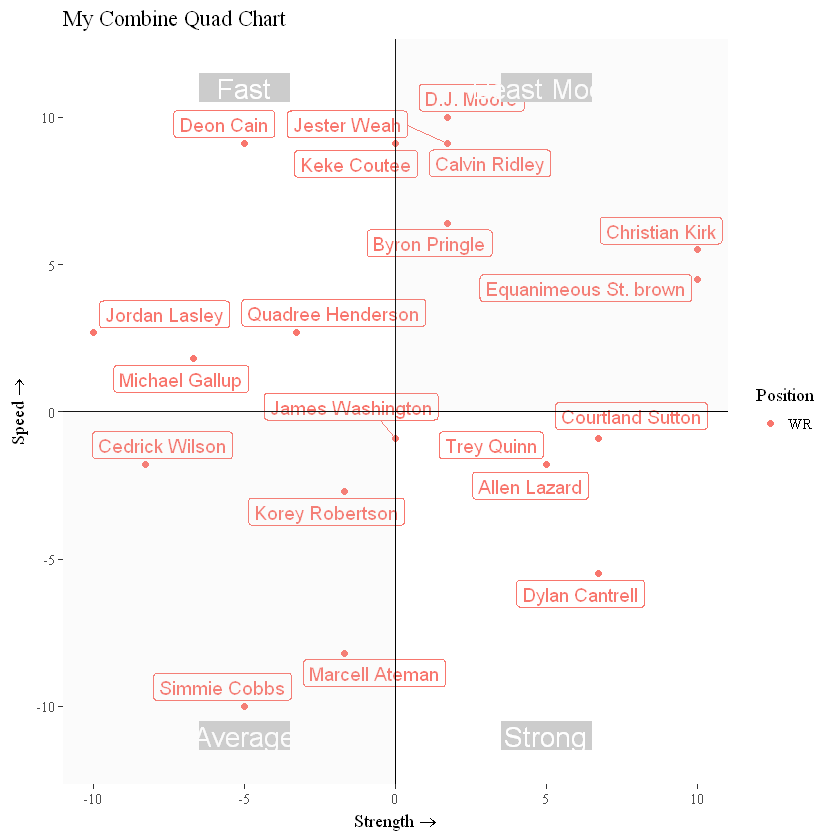

In [27]:
p

This is what our chart looks like after we had the title, subtitle, and caption via the *labs* function

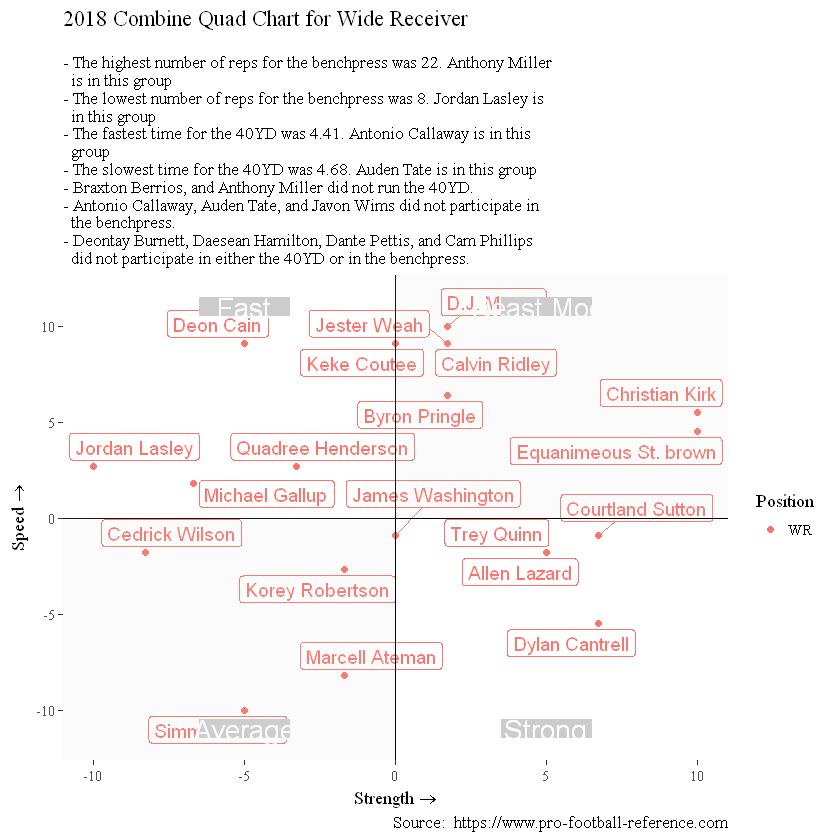

In [28]:
p <- p +
     labs(
         title = chart.title, 
         subtitle = chartsubtitle, 
         caption = chart_source
     )
p

Finally we center the chart title, change the font size of the chart title, change the font size of our subtitles, create a border around our chart, and position our **x** and **y** axis titles towards the lower left corner of our graph, resize our 

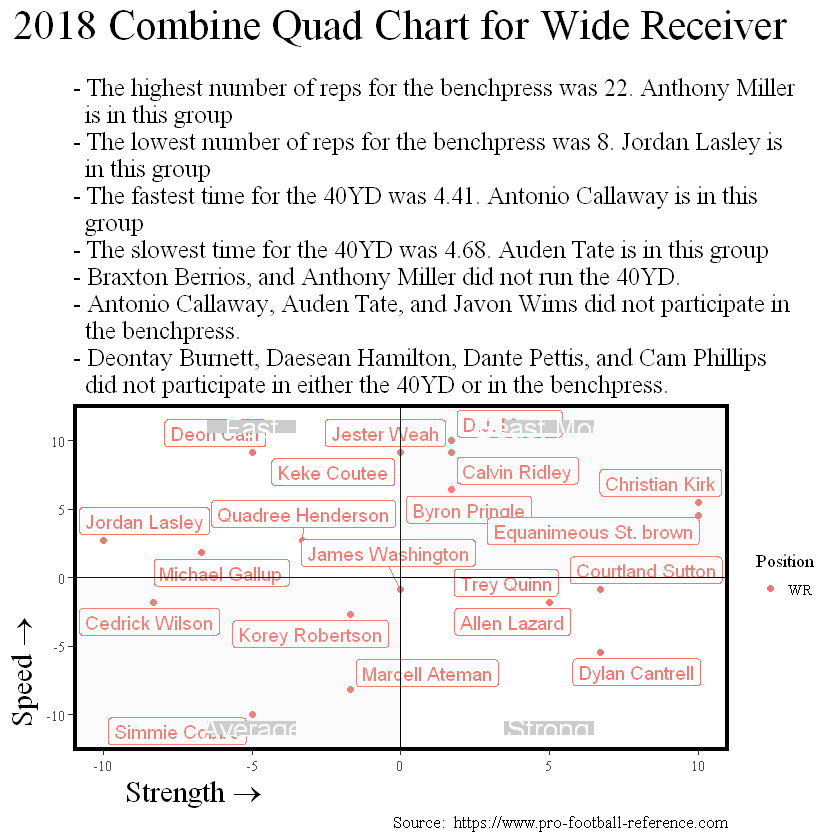

In [29]:
p <- p +
     theme(
          plot.title = element_text(hjust = 0.5, size = 25)
        , plot.subtitle = element_text(size = 15) 
        , panel.border = element_rect(colour = "black", size = 2, fill = NA)
        , axis.title.x = element_text(hjust = 0.1, size = 18)
        , axis.title.y = element_text(hjust = 0.1, size = 18)
     )
p

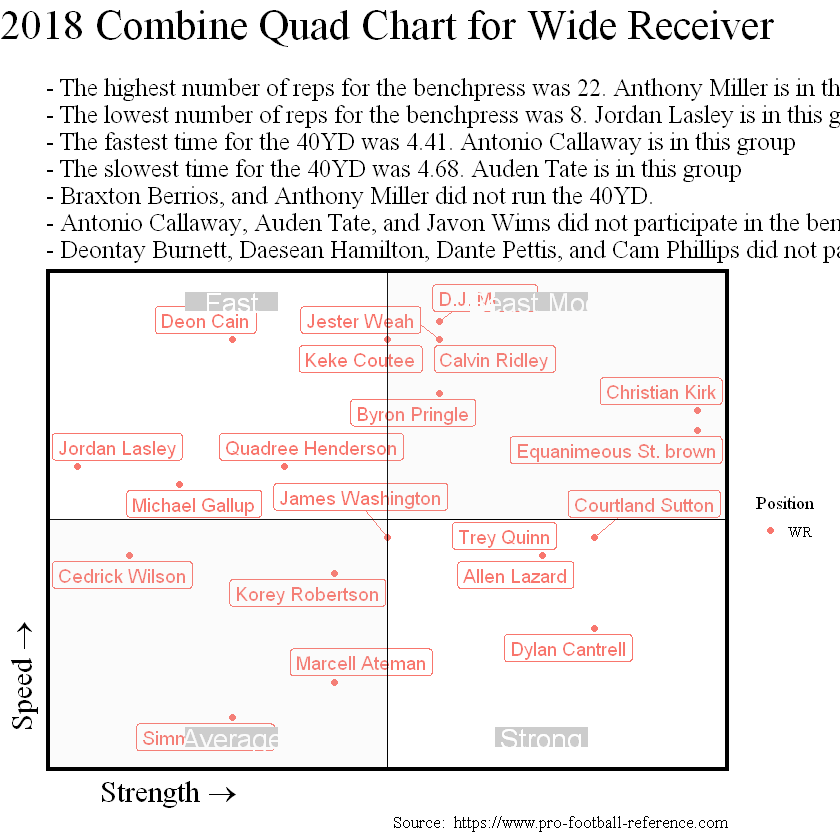

In [30]:
library(tidyverse)
library(ggrepel)
library(ggthemes)
library(scales)
library(stringi)

if (length(unique(dataset$Year)) == 1 & length(unique(dataset$`Position Group`)) == 1) {
  
    selected_position <- unique(dataset$`Position Group`)
    chart.title <- paste(min(dataset$Year), "Combine Quad Chart for", selected_position, sep = " ")

    No40YDSubtitle <- 
        as.character(dataset$Player[which(dataset$`40YD` == 0 & dataset$BenchReps != 0)]) %>%
        paste(collapse = ", ") %>%
        stri_replace_last_fixed(", ", ", and ") %>%
        paste0("- ", .," did not run the 40YD.") %>%
        str_wrap(width = 140, exdent = 2)
    No40YDSubtitleHaveAthletes <-
        length(dataset$Player[which(dataset$`40YD` == 0 & dataset$BenchReps != 0)]) %>%
        {ifelse(. > 0, "Y", "N")}
    
    NoBenchPressSubtitle <- 
        as.character(dataset$Player[which(dataset$`40YD` != 0 & dataset$BenchReps == 0)]) %>%
        paste(collapse = ", ") %>%
        stri_replace_last_fixed(", ", ", and ") %>%
        paste0("- ", .," did not participate in the benchpress.") %>%
        str_wrap(width = 140, exdent = 2)
    NoBenchPressSubtitleHaveAthletes <- 
        length(dataset$Player[which(dataset$`40YD` != 0 & dataset$BenchReps == 0)]) %>%
        {ifelse(. > 0, "Y", "N")}
    
    No40YDAndBenchPressSubtitle <- 
        as.character(dataset$Player[which(dataset$`40YD` == 0 & dataset$BenchReps == 0)]) %>%
        paste(collapse = ", ") %>%
        stri_replace_last_fixed(", ", ", and ") %>%
        paste0("- ", .," did not participate in either the 40YD or in the benchpress.") %>%
        str_wrap(width = 140, exdent = 2)
    No40YDAndBenchPressSubtitleHaveAthletes <- 
        length(dataset$Player[which(dataset$`40YD` == 0 & dataset$BenchReps == 0)]) %>%
        {ifelse(. > 0, "Y", "N")}

    graph_data <-
        dataset %>%
        filter(`40YD` != 0 & BenchReps != 0) %>%
        mutate(
            Scaled.40YD = 
                round(rescale(`40YD` * -1, to = c(-10, 10)), 1)
            ,Scaled.BenchReps = 
                round(rescale(BenchReps, to = c(-10, 10)), 1)
        )

    BestBench <- max(dataset$BenchReps)
    BestBenchAthletes_cv <- as.character(dataset$Player[which(dataset$BenchReps == BestBench)])
    BestBenchAthletesCount <- length(BestBenchAthletes_cv)
    BestBenchAthletes <- 
        BestBenchAthletes_cv %>%
        paste(collapse = ", ") %>%
        stri_replace_last_fixed(", ", ", and ")
    BestBenchSubtitle <- 
        paste0(
            "- The highest number of reps for the benchpress was ",
            BestBench,
            ". ",
            BestBenchAthletes,
            ifelse(BestBenchAthletesCount > 1, " are ", " is "),
            "in this group"
        ) %>%
        str_wrap(width = 140, exdent = 2)

    WorstBench <- min(dataset$BenchReps[dataset$BenchReps != 0])   
    WorstBenchAthletes_cv <- as.character(dataset$Player[which(dataset$BenchReps == WorstBench)])
    WorstBenchAthletesCount <- length(WorstBenchAthletes_cv)
    WorstBenchAthletes <- 
        WorstBenchAthletes_cv %>%
        paste(collapse = ", ") %>%
        stri_replace_last_fixed(", ", ", and ")
    WorstBenchSubtitle <- 
        paste0(
            "- The lowest number of reps for the benchpress was ",
            WorstBench,
            ". ",
            WorstBenchAthletes,
            ifelse(WorstBenchAthletesCount > 1, " are ", " is "),
            "in this group"
        ) %>%
        str_wrap(width = 140, exdent = 2)

    Best40YD <- min(dataset$`40YD`[dataset$`40YD` != 0])
    Best40YDAthletes_cv <- as.character(dataset$Player[which(dataset$`40YD` == Best40YD)])
    Best40YDAthletesCount <- length(Best40YDAthletes_cv)
    Best40YDAthletes <- 
        Best40YDAthletes_cv %>%
        paste(collapse = ", ") %>%
        stri_replace_last_fixed(", ", ", and ")
    Best40YDSubtitle <- 
        paste0(
            "- The fastest time for the 40YD was ",
            Best40YD,
            ". ",
            Best40YDAthletes,
            ifelse(Best40YDAthletesCount > 1, " are ", " is "),
            "in this group"
        ) %>%
        str_wrap(width = 140, exdent = 2)

    Worst40YD <- max(dataset$`40YD`)
    Worst40YDAthletes_cv <- as.character(dataset$Player[which(dataset$`40YD` == Worst40YD)])
    Worst40YDAthletesCount <- length(Worst40YDAthletes_cv)
    Worst40YDAthletes <- 
        Worst40YDAthletes_cv %>%
        paste(collapse = ", ") %>%
        stri_replace_last_fixed(", ", ", and ")
    Worst40YDSubtitle <- 
        paste0(
            "- The slowest time for the 40YD was ",
            Worst40YD,
            ". ",
            Worst40YDAthletes,
            ifelse(Worst40YDAthletesCount > 1, " are ", " is "),
            "in this group"
        ) %>%
        str_wrap(width = 140, exdent = 2)
    
    chartsubtitle <-
            paste0(
                ifelse(BestBenchAthletesCount == 0,"",paste0("\n", BestBenchSubtitle)),
                ifelse(WorstBenchAthletesCount == 0,"",paste0("\n", WorstBenchSubtitle)),
                ifelse(Best40YDAthletesCount == 0,"",paste0("\n", Best40YDSubtitle)),
                ifelse(Worst40YDAthletesCount == 0,"",paste0("\n", Worst40YDSubtitle)),
                ifelse(No40YDSubtitleHaveAthletes == "Y",paste0("\n", No40YDSubtitle),""),
                ifelse(NoBenchPressSubtitleHaveAthletes == "Y",paste0("\n", NoBenchPressSubtitle),""),
                ifelse(No40YDAndBenchPressSubtitleHaveAthletes == "Y",paste0("\n", No40YDAndBenchPressSubtitle),"")
            )
    
    chart_source <- "Source:  https://www.pro-football-reference.com"

    p <- ggplot(graph_data, aes(x = Scaled.BenchReps, y = Scaled.40YD, col = Position)) +
         geom_point() +
         geom_label_repel(aes(label = Player), size = 4, show.legend = FALSE) +
         geom_hline(yintercept = 0) +
         geom_vline(xintercept = 0) +

         # Squares for quad labels
         annotate("rect", xmin = -3.5, xmax = -6.5, ymin = -11.5, ymax = -10.5, fill = "grey80") +
         annotate("rect", xmin = -3.5, xmax = -6.5, ymin = 10.5, ymax = 11.5, fill = "grey80") +
         annotate("rect", xmin = 3.5, xmax = 6.5, ymin = -11.5, ymax = -10.5, fill = "grey80") +
         annotate("rect", xmin = 3.5, xmax = 6.5, ymin = 10.5, ymax = 11.5, fill = "grey80") +
    
         # quad labels
         annotate("text", x = -5, y = -11, label = "Average", color = "white", size = 6) +
         annotate("text", x = -5, y = 11, label = "Fast", color = "white", size = 6) +
         annotate("text", x = 5, y = -11, label = "Strong", color = "white", size = 6) +
         annotate("text", x = 5, y = 11, label = "Beast Mode", color = "white", size = 6) +

         # Shade lower left quadrant
         annotate("rect", xmin = -Inf, xmax = 0.0, ymin = -Inf, ymax = 0, alpha = 0.1, fill = "lightgrey") +
        
         # Shade upper right quadrant
         annotate("rect", xmin = 0.0, xmax = Inf, ymin = 0.0, ymax = Inf, alpha = 0.1, fill = "lightgrey") +
        
         # Titles
         xlab(bquote("Strength" ~ symbol('\256'))) +
         ylab(bquote("Speed" ~ symbol('\256'))) +
         #ggtitle(chart.title, subtitle = chartsubtitle) +
         labs(title = chart.title, subtitle = chartsubtitle, caption = chart_source) +

         # Prettying things up
         theme_tufte() +
         theme(
              plot.title = element_text(hjust = 0.5, size = 25)
            , plot.subtitle = element_text(size = 15) 
            , panel.border = element_rect(colour = "black", size = 2, fill = NA)
            , axis.title.x = element_text(hjust = 0.1, size = 18)
            , axis.title.y = element_text(hjust = 0.1, size = 18)
         ) +
         scale_x_continuous(labels = NULL, breaks = NULL) +
         scale_y_continuous(labels = NULL, breaks = NULL) 
    
         p

} else {
    p <- ggplot(dataset, aes(x = BenchReps, y = `40YD`)) +
         geom_blank() +
         scale_x_continuous(
              labels = NULL
            , breaks = NULL
        ) +
         scale_y_continuous(
              labels = NULL
            , breaks = NULL
         ) +
         labs(x = NULL, y = NULL) +
         theme_classic()
    p
}